# Pacbot Localization using Computer Vision
This notebook outlines how to use ArUco marker functionality (bundled within OpenCV) to create and detect tags for more robust localization. In previous years, Pacbot's computer vision to localize the robot was done using color masking, which was less accurate and more prone to lighting disturbances.

In [1]:
import cv2
from cv2 import aruco
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Any
from ipywidgets import interact                                                      # type: ignore

## Part 1: ArUco Markers

### Generating ArUco Markers

An ArUco (**A**ugmented **R**eality from the **U**niversity of **Co**rdoba, located in Spain) marker is like a QR code. For a given size, an ArUco marker can be detected and classified, **regardless** of rotation or other affine transformations (like stretching or shearing of an axis) applied to it. Luckily for us, OpenCV has the ability to generate these markers, so we don't have to reinvent the wheel.

The code below demonstrates how to generate 4x4 ArUco markers with varying IDs. Each marker within the same group is uniquely identifiable, which will be useful later when determining where the Pacbot is relative to other landmarks within the maze.

In [2]:
# A dictionary of 4x4 ArUco markers
dictionary = aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)

# Method to generate an ArUco marker, then display it to the screen
@interact(id = (0, 10))                                                              # type: ignore
def generateShow(id: int) -> None:
    marker_image = aruco.generateImageMarker(dictionary, id, 6)
    plt.imshow(marker_image, cmap='gray')                                            # type: ignore
    plt.show()                                                                       # type: ignore

interactive(children=(IntSlider(value=5, description='id', max=10), Output()), _dom_classes=('widget-interact'…

### Detecting ArUco Markers

Of course, these markers wouldn't be too useful if we couldn't detect them and figure out where they are, relative to an uncorrelated (noisy) background. To demonstrate a use case, let's make a 'test-bench', consisting of an ArUco marker embedded within a noisy background:

generating marker with id = 87


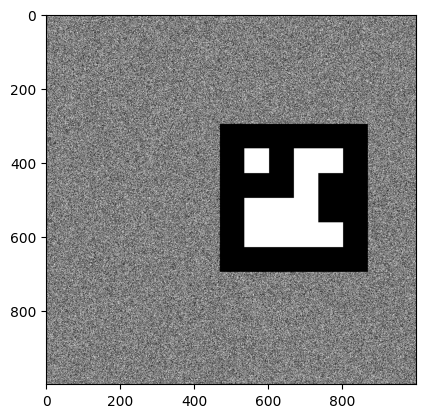

In [3]:
# Function to generate an ArUco marker of a given ID and size, with a random rotation
def newMarker(id: int, size: int):
    print(f'generating marker with id = {id}')
    return np.rot90(
        np.array(aruco.generateImageMarker(dictionary, id, size)),
        random.randint(0, 3) # Up to 3 rotations
    )

# Function to generate a noisy image
def noisyImage(size: int):
    return 255 * np.random.rand(size, size)

# Set the image and marker sizes
IMAGE_SIZE = 1000
MARKER_SIZE = 400

# Generate an image and marker, and copy the marker within the image
testImage = noisyImage(size = IMAGE_SIZE)
marker = newMarker(id = random.randint(0, 100), size = MARKER_SIZE)
rowOffset = random.randint(1, IMAGE_SIZE - MARKER_SIZE - 1)
colOffset = random.randint(1, IMAGE_SIZE - MARKER_SIZE - 1)
testImage[rowOffset:rowOffset+MARKER_SIZE, colOffset:colOffset+MARKER_SIZE] = marker
testImage = testImage.astype(np.uint8)

# Show the image
plt.imshow(testImage, cmap='gray')                                                   # type: ignore

Below is some code demonstrating how to detect an ArUco marker within our test-bench image. You can compare the detected marker ID (printed by the below cell) with the generated ID above, and you'll see that they always match. We can also use the positions of the corners to get the centroid of the marker (this centroid-finding is called **localization** when referring to the robot, and **mapping** when referring to the surroundings).

detected marker with id 87 - centroid at (row 496, col 669)


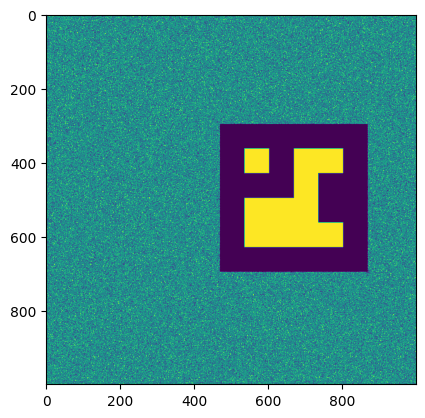

In [4]:
# Instantiate a new ArUco detector
detector = aruco.ArucoDetector(dictionary, aruco.DetectorParameters())

# Detect our test-bench marker
corners, ids, rejectedImgPoints = detector.detectMarkers(testImage)
frame_markers = aruco.drawDetectedMarkers(testImage, corners, ids)

# Show the labeled image
plt.imshow(frame_markers)                                                            # type: ignore

# Calculate the position of the centroid
centroid = (int(corners[0][0][:, 1].mean()), int(corners[0][0][:, 0].mean()))

# Print the detected image ID
print(f'detected marker with id {ids[0,0]} - centroid at (row {centroid[0]}, col {centroid[1]})')

### Multiple ArUco Markers

Now comes the fun part: we demonstrate that even if there are many ArUco markers, we can still detect and localize each and every one of them independently. We simulate four markers placed near, but not exactly at, the 'corners' of a noisy image (we'll see why this becomes relevant soon, in Part 2):

generating marker with id = 0
generating marker with id = 1
generating marker with id = 2
generating marker with id = 3


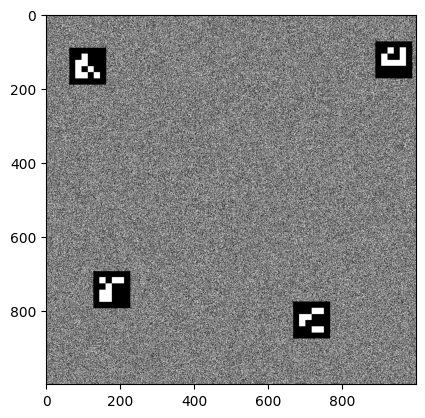

In [5]:
# Set the image and marker sizes
IMAGE_SIZE = 1000
MARKER_SIZE = 100

# Marker location bounds, based on parity (if this bit of the marker index is 0, return the lower
# set of bounds, otherwise return the higher set of bounds)
def markerBounds(index: int, bit: int):
    parity = (index >> bit) & 1
    if parity == 0:
        return random.randint(MARKER_SIZE // 10, IMAGE_SIZE // 4 - MARKER_SIZE)
    else:
        return random.randint(3 * IMAGE_SIZE // 4 - MARKER_SIZE, IMAGE_SIZE - 11 * MARKER_SIZE//10)

# Generate an image and marker, and for each generated marker, copy the marker within the image
testImage = noisyImage(size = IMAGE_SIZE)
for markerIndex in range(4):
    marker = newMarker(markerIndex, size = MARKER_SIZE)
    rowOffset = markerBounds(markerIndex, 1)
    colOffset = markerBounds(markerIndex, 0)
    testImage[rowOffset:rowOffset+MARKER_SIZE, colOffset:colOffset+MARKER_SIZE] = marker
testImage = testImage.astype(np.uint8)

# Show the image
plt.imshow(testImage, cmap='gray')                                                   # type: ignore

It may be surprising, but the marker detection code barely changes! The only real difference here is that we have to calculate multiple centroids, corresponding to each of the four markers.

detected marker w/ id 1 - centroid at (row 123, col 939)
detected marker w/ id 3 - centroid at (row 826, col 717)
detected marker w/ id 2 - centroid at (row 744, col 177)
detected marker w/ id 0 - centroid at (row 140, col 112)


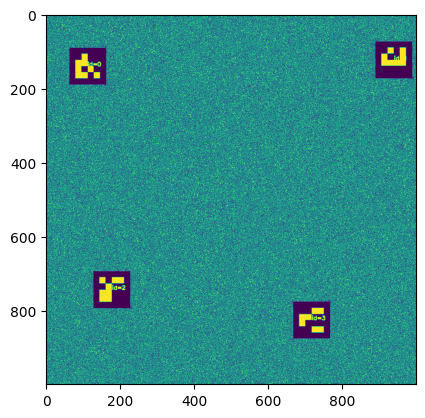

In [6]:
# Instantiate a new ArUco detector
detector = aruco.ArucoDetector(dictionary, aruco.DetectorParameters())

# Detect our test-bench marker
corners, ids, rejectedImgPoints = detector.detectMarkers(testImage)
frame_markers = aruco.drawDetectedMarkers(testImage, corners, ids)

# Show the labeled image
plt.imshow(frame_markers)                                                            # type: ignore

for j in range(len(ids)):

    # Calculate the position of the centroid
    centroid = (int(corners[j][0][:, 1].mean()), int(corners[j][0][:, 0].mean()))

    # Print the detected image ID
    print(f'detected marker w/ id {ids[j,0]} - centroid at (row {centroid[0]}, col {centroid[1]})')

## Part 2: Camera Perspectives

Before you run code from this part, make sure you run and understand the code from Part 1, as we will be re-using a lot of those functions.

### The Four Point Transform

This section will focus on the Four Point Transform, a method to straighten out top-down (bird's eye view) camera images that get warped by an imperfect viewing angle.

What's the point of a Four Point transform? Consider this: suppose you have to scan a paper document (like an index card) with your phone. The page itself is a rectangle, but at some angles, it may appear to be a parallelogram, or even a trapezoid, though the camera:

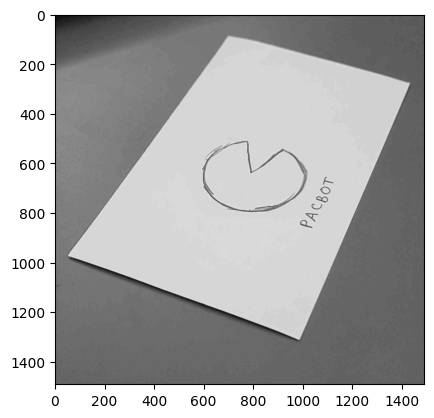

In [7]:
img = cv2.imread('perspective.jpg', 0)
plt.imshow(img, cmap='gray')                                                         # type: ignore

Well that doesn't look good. Do we have to throw this image away and take a new one? 

Not really. There's a trick to making the scan of the index card rectangular again. The key observation is that the sides of the paper are still relatively straight. So, if we can find some way to map the corners of the back to a rectangle, and then copy over the points within the index card using the same mapping, we can recover the original rectangle.

The first step to fixing our index card scan is to detect the corners of the image. **Canny Edge Detection** is an algorithm which uses thresholding of changes in brightness to find edges:

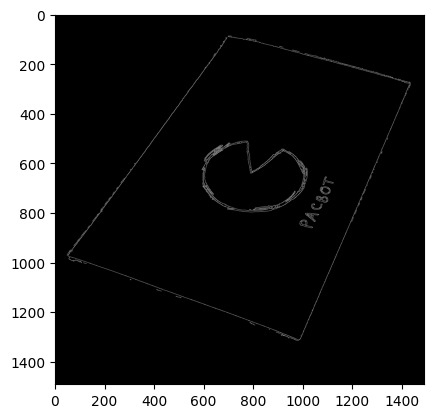

In [8]:
edges = cv2.Canny(img, 70, 150)
plt.imshow(edges, cmap='gray')                                                       # type: ignore

Looking at the result above, we can devise a clever approach for finding the corners of our index card, by noticing that the highest, leftmost, rightmost, and lowest white pixels are located at the corners of the paper. So, all we have to do is detect the extremes of the canny edge detection result. 

**Note:** this approach of detecting the extremes of an edge-detected image doesn't usually work, both due to edges introduced by shadows and variation in camera perspectives, but for this exercise it should suffice. 

After running the next cell, you should be able to see red markers drawn at the four corners.

highest at   (row 88, col 699)
lowest at    (row 1317, col 981)
leftmost at  (row 972, col 48)
rightmost at (row 283, col 1433)


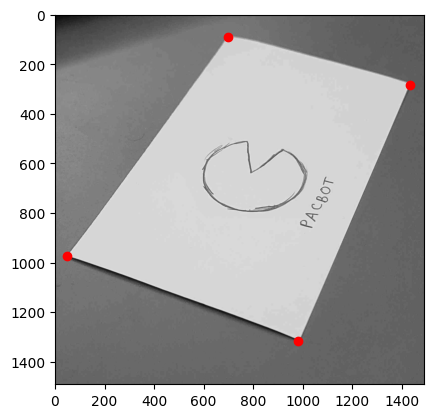

In [9]:
# Use numpy to get a list of locations where the edge detection pixels are white
white_pixels = np.argwhere(edges)

# Sort the white pixels in both vertical and horizontal directions, so we can find the extremes
sorted_UD = white_pixels[np.argsort(white_pixels[:,0]), :] # sorted up-to-down
sorted_LR = white_pixels[np.argsort(white_pixels[:,1]), :] # sorted left-to-write

# Get the highest white pixel (first in the up-to-down sorted list)
highest = sorted_UD[0]
print(f'highest at   (row {highest[0]}, col {highest[1]})')

# Get the lowest white pixel (last in the up-to-down sorted list)
lowest = sorted_UD[-1]
print(f'lowest at    (row {lowest[0]}, col {lowest[1]})')

# Get the leftmost white pixel (first in the left-to-right sorted list)
leftmost = sorted_LR[0]
print(f'leftmost at  (row {leftmost[0]}, col {leftmost[1]})')

# Get the rightmost white pixel (last in the left-to-write sorted list)
rightmost = sorted_LR[-1]
print(f'rightmost at (row {rightmost[0]}, col {rightmost[1]})')

# Plot the original image, with marker annotations at the corners
plt.imshow(img, cmap='gray')                                                         # type: ignore
plt.plot([highest[1]], [highest[0]], "ro")                                           # type: ignore
plt.plot([lowest[1]], [lowest[0]], "ro")                                             # type: ignore
plt.plot([leftmost[1]], [leftmost[0]], "ro")                                         # type: ignore
plt.plot([rightmost[1]], [rightmost[0]], "ro")                                       # type: ignore

Now it's time to perform the Four Point Transform! Examine the code below and make sure you understand it, because we'll be using `four_point_transform` function a lot.

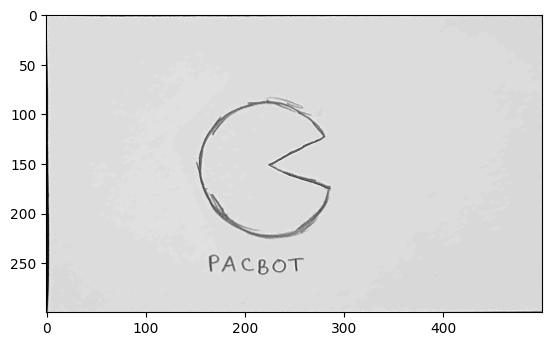

In [10]:
# For type-checking purposes
IntArray = np.ndarray[Any, np.dtype[np.intp]]
MatLike = cv2.typing.MatLike

def four_point_transform(
    image: MatLike,    # original image
    pointTL: IntArray, # 'top-left' corner
    pointTR: IntArray, # 'top-right' corner
    pointBL: IntArray, # 'bottom-left' corner
    pointBR: IntArray, # 'bottom-right' corner
    height: int,       # result image height
    width: int         # result image width
) -> MatLike:
    
    # Order the points, swapping the coordinates so x will be first (as opposed to row)
    ordered_points = np.array([
        [pointTL[1], pointTL[0]],
        [pointTR[1], pointTR[0]],
        [pointBR[1], pointBR[0]],
        [pointBL[1], pointBL[0]]
    ]).astype('float32')

    # Create an array describing the final locations of those points
    result = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ]).astype('float32')

    # Calculate a perspective matrix
    transform = cv2.getPerspectiveTransform(ordered_points, result)
    
    # Return the result
    return cv2.warpPerspective(image, transform, (width, height))

# Classify the points based on where they'll be on the card
pointTL = leftmost  # top-left of the card
pointTR = highest   # top-right of the card
pointBL = lowest    # bottom-left of the card
pointBR = rightmost # bottom-right of the card

# We know this is a 3x5 index card, so we can easily come up with heights in this aspect ratio
height = 300
width  = 500

result = four_point_transform(img, pointTL, pointTR, pointBL, pointBR, height, width)
plt.imshow(result, cmap='gray')                                                      # type: ignore

The result above looks exactly as I drew it on the index card! Hopefully it's clear why Four Point Transforms are useful for applications involving a bird's eye view of a map. Usually, determining the corners of the region is the toughest part, as changes in lighting and the camera angle can potentially change the detected locations of the corners. That's where robust marker mapping techniques, like ArUco, can help.

### Perspective Transforms with ArUco Markers

Let's make a new test-bench image. Just like we did in Part 1, we'll generate four ArUco markers (hopefully it's clear now that they correspond to the four corners of the region we care about) above a noisy background, along with a white circle near the center. 

For now, think of this white circle as the 'Pacbot', and the quadrilateral region between the four marked corners as the 'maze', which we know should be a rectangle, but there's probably some warping due to the camera angle. Where is Pacman within the maze? Determining that is the goal of the next two sections!

generating marker with id = 0
generating marker with id = 1
generating marker with id = 2
generating marker with id = 3


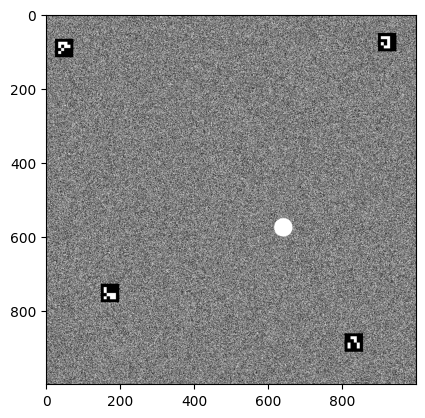

In [11]:
# Set the image size, marker size, and Pacman radius
IMAGE_SIZE = 1000
MARKER_SIZE = 50
PACMAN_RADIUS = 25

# Generate an image and marker, and for each generated marker, copy the marker within the image
testImage = noisyImage(size = IMAGE_SIZE)
for markerIndex in range(4):
    marker = newMarker(markerIndex, size = MARKER_SIZE)
    rowOffset = markerBounds(markerIndex, 1)
    colOffset = markerBounds(markerIndex, 0)
    testImage[rowOffset:rowOffset+MARKER_SIZE, colOffset:colOffset+MARKER_SIZE] = marker
testImage = testImage.astype(np.uint8)

# Draw a circle corresponding to Pacman
rowOffsetP = random.randint(IMAGE_SIZE // 4 + PACMAN_RADIUS, 3 * IMAGE_SIZE // 4 - PACMAN_RADIUS)
colOffsetP = random.randint(IMAGE_SIZE // 4 + PACMAN_RADIUS, 3 * IMAGE_SIZE // 4 - PACMAN_RADIUS)
pacbot = cv2.circle(testImage, (rowOffsetP, colOffsetP), PACMAN_RADIUS, (255, 255, 255), -1)

# Show the image
plt.imshow(testImage, cmap='gray')                                                   # type: ignore

You know the deal. We can localize the corners just like we did before in Part 1, using an ArUco detector. An added benefit is that we know which corner is which, in case the camera is mounted upside down. For now, we'll assume that our image isn't upside down - that is, top-left marker (with id 0) will always be at the top left of our transformed image, and the bottom-right marker (with id 3) will always be at the bottom right of our transformed image.

detected marker w/ id 3 - centroid at (row 887, col 831)
detected marker w/ id 2 - centroid at (row 753, col 172)
detected marker w/ id 0 - centroid at (row 91, col 48)
detected marker w/ id 1 - centroid at (row 75, col 921)


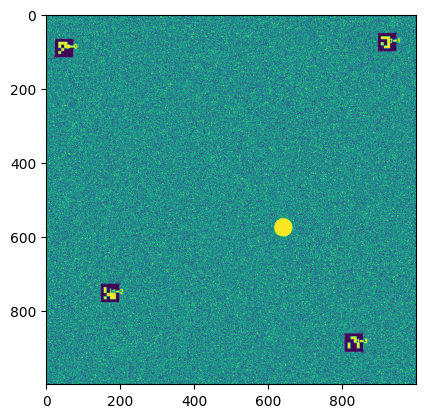

In [12]:
# Instantiate a new ArUco detector
detector = aruco.ArucoDetector(dictionary, aruco.DetectorParameters())

# Detect our test-bench marker
corners, ids, rejectedImgPoints = detector.detectMarkers(testImage)
frame_markers = aruco.drawDetectedMarkers(testImage, corners, ids)

# Show the labeled image
plt.imshow(frame_markers)                                                            # type: ignore

for j in range(len(ids)):

    # Calculate the position of the centroid
    centroid = (int(corners[j][0][:, 1].mean()), int(corners[j][0][:, 0].mean()))

    # Print the detected image ID
    print(f'detected marker w/ id {ids[j,0]} - centroid at (row {centroid[0]}, col {centroid[1]})')

The next step is to use the `four_point_transform` method we wrote before.

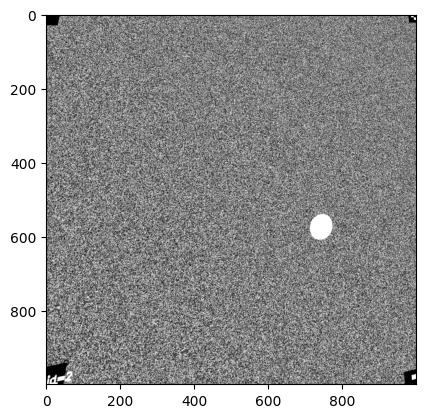

In [13]:
# Initialize the four corners
pointTL = np.array([])
pointTR = np.array([])
pointBL = np.array([])
pointBR = np.array([])

for j in range(len(ids)):

    # Find the coordinates of this centroid
    centroid = np.array([
        int(corners[j][0][:, 1].mean()),
        int(corners[j][0][:, 0].mean())
    ]).astype(np.intp)

    # Top-left of the maze
    if ids[j, 0] == 0:
        pointTL = centroid

    # Top-right of the maze
    if ids[j, 0] == 1:
        pointTR = centroid

    # Bottom-left of the maze
    if ids[j, 0] == 2:
        pointBL = centroid

    # Bottom-right of the maze
    if ids[j, 0] == 3:
        pointBR = centroid

# We assume for now that the maze region is supposed to be a square
height = 1000
width  = 1000

result = four_point_transform(testImage, pointTL, pointTR, pointBL, pointBR, height, width)
plt.imshow(result, cmap='gray')                                                      # type: ignore

### Brightness-Based Localization

Now comes the interesting part: we have to localize the robot using brightness (in this case, the color white), which we haven't done before!

The first step is to 'drown out the background noise' of the result by using another filter. Instead of Canny Edge Detection (what's considered to be a *high-pass filter*), we now use a **Gaussian Blur** (a *low-pass filter*), which uses averages of pixel brightness over a moving window to construct a smoother version of the image:

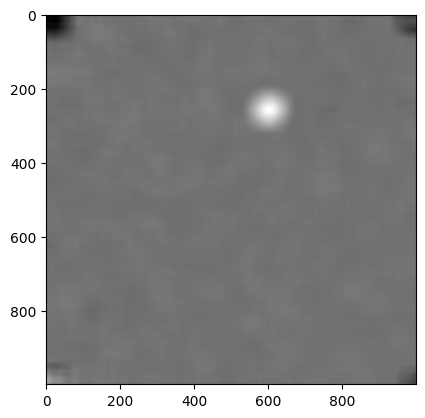

In [87]:
# We arbitrarily choose a 61x61 window for Gaussian blurring (the window dimensions must be odd)
blurred = cv2.GaussianBlur(result, ksize=(61, 61), sigmaX=40)
plt.imshow(blurred, cmap='gray')                                                     # type: ignore

Now that the image has been blurred, we can use a threshold to remove everything below a brightness of 200 (i.e., everything that isn't the Pacbot).

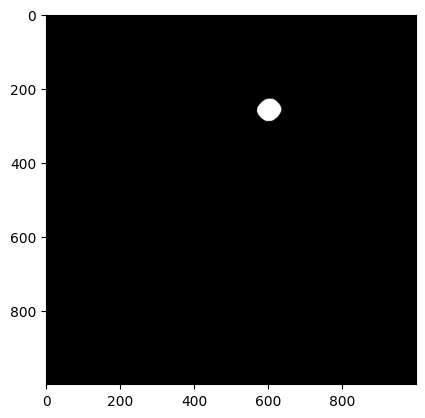

In [88]:
_, pacbot = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
plt.imshow(pacbot, cmap='gray')                                                      # type: ignore

What if we didn't use the Gaussian blur? It could be a big problem, as random white pixels scattered throughout the noise and markers may show up in our tresholded image. See for yourself:

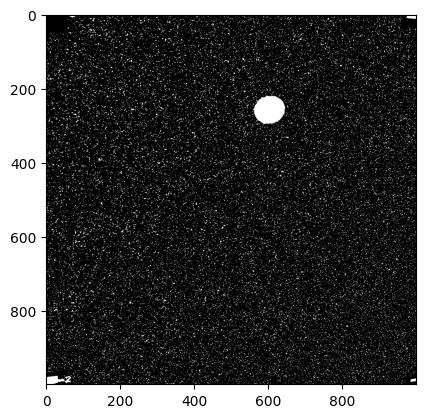

In [89]:
_, pacbot_bad = cv2.threshold(result, 200, 255, cv2.THRESH_BINARY)
plt.imshow(pacbot_bad, cmap='gray')                                                      # type: ignore

Going back to our blurred then thresholded image, we can find the centroid by taking a spatial average of all the coordinates where the pixels are white:

centroid at (row 258, col 602)


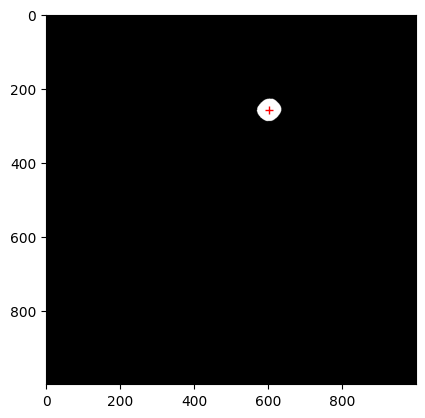

In [90]:
# Calculate the centroid
centroid = list(map(int, map(np.mean, np.where(pacbot))))

# Print out the centroid coordinates
print(f'centroid at (row {centroid[0]}, col {centroid[1]})')

# Show the centroid
plt.imshow(pacbot, cmap='gray')                                                      # type: ignore
plt.plot([centroid[1]], [centroid[0]], "r+")                                         # type: ignore

Now, relative to some scale of the maze size, we know where Pacbot is!

### Localization **without** Transforming

While writing this, it occurred to me that it might be cumbersome to use the Four Point Transform on the camera feed every single frame. Once we know the perspective transform matrix, can't we figure out where Pacbot is on the original image? It would save quite a bit of computation power, and it could make setting up the camera easier too, since we can see how close the ArUco markers are to being off-screen.

Let's experiment with this idea. We start by bringing back the index card example (no code has changed yet):

highest at   (row 88, col 699)
lowest at    (row 1317, col 981)
leftmost at  (row 972, col 48)
rightmost at (row 283, col 1433)


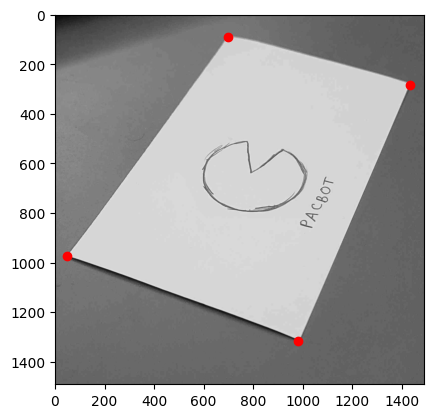

In [91]:
# Perform Canny edge detection
edges = cv2.Canny(img, 70, 150)

# Use numpy to get a list of locations where the edge detection pixels are white
white_pixels = np.argwhere(edges)

# Sort the white pixels in both vertical and horizontal directions, so we can find the extremes
sorted_UD = white_pixels[np.argsort(white_pixels[:,0]), :] # sorted up-to-down
sorted_LR = white_pixels[np.argsort(white_pixels[:,1]), :] # sorted left-to-write

# Get the highest white pixel (first in the up-to-down sorted list)
highest = sorted_UD[0]
print(f'highest at   (row {highest[0]}, col {highest[1]})')

# Get the lowest white pixel (last in the up-to-down sorted list)
lowest = sorted_UD[-1]
print(f'lowest at    (row {lowest[0]}, col {lowest[1]})')

# Get the leftmost white pixel (first in the left-to-right sorted list)
leftmost = sorted_LR[0]
print(f'leftmost at  (row {leftmost[0]}, col {leftmost[1]})')

# Get the rightmost white pixel (last in the left-to-write sorted list)
rightmost = sorted_LR[-1]
print(f'rightmost at (row {rightmost[0]}, col {rightmost[1]})')

# Plot the original image, with marker annotations at the corners
plt.imshow(img, cmap='gray')                                                         # type: ignore
plt.plot([highest[1]], [highest[0]], "ro")                                           # type: ignore
plt.plot([lowest[1]], [lowest[0]], "ro")                                             # type: ignore
plt.plot([leftmost[1]], [leftmost[0]], "ro")                                         # type: ignore
plt.plot([rightmost[1]], [rightmost[0]], "ro")                                       # type: ignore

Let's take a look at two variants of our `four_point_transform` function, which I designed to return the perspective matrix and its *inverse*.

In [92]:
# For type-checking purposes
IntArray = np.ndarray[Any, np.dtype[np.intp]]
MatLike = cv2.typing.MatLike

def four_point_matrix(
    pointTL: IntArray, # 'top-left' corner
    pointTR: IntArray, # 'top-right' corner
    pointBL: IntArray, # 'bottom-left' corner
    pointBR: IntArray, # 'bottom-right' corner
    height: int,       # result image height
    width: int         # result image width
) -> MatLike:
    
    # Order the points, swapping the coordinates so x will be first (as opposed to row)
    ordered_points = np.array([
        [pointTL[1], pointTL[0]],
        [pointTR[1], pointTR[0]],
        [pointBR[1], pointBR[0]],
        [pointBL[1], pointBL[0]]
    ]).astype('float32')

    # Create an array describing the final locations of those points
    result = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ]).astype('float32')

    # Calculate a perspective matrix
    return cv2.getPerspectiveTransform(ordered_points, result)

def four_point_inverse(
    pointTL: IntArray, # 'top-left' corner
    pointTR: IntArray, # 'top-right' corner
    pointBL: IntArray, # 'bottom-left' corner
    pointBR: IntArray, # 'bottom-right' corner
    height: int,       # result image height
    width: int         # result image width
) -> MatLike:

    # Calculate an INVERSE perspective matrix
    return np.linalg.inv(
        four_point_matrix(pointTL, pointTR, pointBL, pointBR, height, width)         # type: ignore
    )                                                                                # type: ignore

# Classify the points based on where they'll be on the card
pointTL = leftmost  # top-left of the card
pointTR = highest   # top-right of the card
pointBL = lowest    # bottom-left of the card
pointBR = rightmost # bottom-right of the card

# We know this is a 3x5 index card, so we can easily come up with heights in this aspect ratio
height = 300
width  = 500

# Calculate the four-point transform matrix
inverse = four_point_inverse(pointTL, pointTR, pointBL, pointBR, height, width)

Now we can use matrix operations to map from reference points on a 3-by-5 index card to points on our original image:

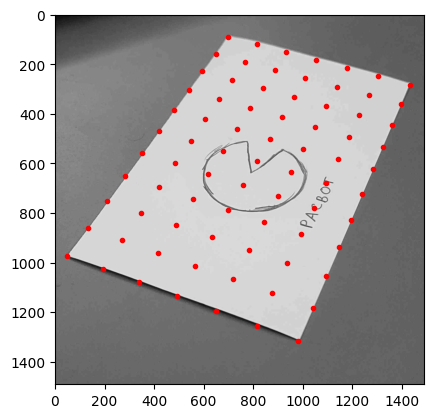

In [93]:
# Plot the original image
plt.imshow(img, cmap='gray')                                                         # type: ignore

for transformed_row in range(0, 301, 50):
    for transformed_col in range(0, 501, 50):

        # Matrix multiplication to get a vector
        vector = inverse @ np.array([transformed_col, transformed_row, 1])

        # Plot a point based on this result
        plt.plot([vector[0]/vector[2]], [vector[1]/vector[2]], "r.")                 # type: ignore

Looks good! Now we have a way to see what the transformations would look like on the original image, and how far apart gridlines on the transformed image may be.

Let's try this on the original ArUco marker image too. Bringing back that test-bench:

generating marker with id = 0
generating marker with id = 1
generating marker with id = 2
generating marker with id = 3


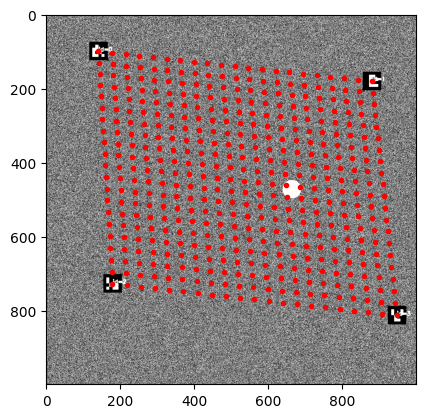

In [98]:
# Set the image size, marker size, and Pacman radius
IMAGE_SIZE = 1000
MARKER_SIZE = 50
PACMAN_RADIUS = 25

# Generate an image and marker, and for each generated marker, copy the marker within the image
testImage = noisyImage(size = IMAGE_SIZE)
for markerIndex in range(4):
    marker = newMarker(markerIndex, size = MARKER_SIZE)
    rowOffset = markerBounds(markerIndex, 1)
    colOffset = markerBounds(markerIndex, 0)
    testImage[rowOffset:rowOffset+MARKER_SIZE, colOffset:colOffset+MARKER_SIZE] = marker
testImage = testImage.astype(np.uint8)

# Draw a circle corresponding to Pacman
rowOffsetP = random.randint(IMAGE_SIZE // 4 + PACMAN_RADIUS, 3 * IMAGE_SIZE // 4 - PACMAN_RADIUS)
colOffsetP = random.randint(IMAGE_SIZE // 4 + PACMAN_RADIUS, 3 * IMAGE_SIZE // 4 - PACMAN_RADIUS)
pacbot = cv2.circle(testImage, (rowOffsetP, colOffsetP), PACMAN_RADIUS, (255, 255, 255), -1)

# Instantiate a new ArUco detector
detector = aruco.ArucoDetector(dictionary, aruco.DetectorParameters())

# Detect our test-bench marker
corners, ids, rejectedImgPoints = detector.detectMarkers(testImage)
frame_markers = aruco.drawDetectedMarkers(testImage, corners, ids)

# Initialize the four corners
pointTL = np.array([])
pointTR = np.array([])
pointBL = np.array([])
pointBR = np.array([])

for j in range(len(ids)):

    # Find the coordinates of this centroid
    centroid = np.array([
        int(corners[j][0][:, 1].mean()),
        int(corners[j][0][:, 0].mean())
    ]).astype(np.intp)

    # Top-left of the maze
    if ids[j, 0] == 0:
        pointTL = centroid

    # Top-right of the maze
    if ids[j, 0] == 1:
        pointTR = centroid

    # Bottom-left of the maze
    if ids[j, 0] == 2:
        pointBL = centroid

    # Bottom-right of the maze
    if ids[j, 0] == 3:
        pointBR = centroid

# We assume for now that the maze region is supposed to be a square
height = 1000
width  = 1000

inverse = four_point_inverse(pointTL, pointTR, pointBL, pointBR, height, width)

# Plot the original image
plt.imshow(testImage, cmap='gray')                                                   # type: ignore

for transformed_row in range(0, 1001, 50):
    for transformed_col in range(0, 1001, 50):

        # Matrix multiplication to get a vector
        vector = inverse @ np.array([transformed_col, transformed_row, 1])

        # Plot a point based on this result
        plt.plot([vector[0]/vector[2]], [vector[1]/vector[2]], "r.")                 # type: ignore

Now we effectively have an overlay which can show us where the perspective transform *thinks* the maze cell boundaries are, which is really helpful. 

Still, I have to prove to you that we can apply the whole blurring and thresholding approach to the original image and still get a very similar result.

To start, let's do the same blurring and thresholding approach as before, to see where the centroid is:

centroid at (row 516, col 668)


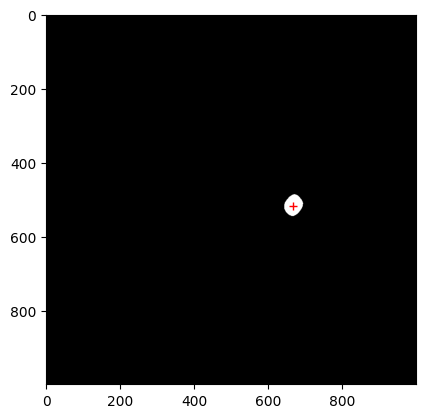

In [99]:
result = four_point_transform(testImage, pointTL, pointTR, pointBL, pointBR, height, width)
blurred = cv2.GaussianBlur(result, ksize=(61, 61), sigmaX=40)
_, pacbot = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

# Calculate the centroid
centroid = list(map(int, map(np.mean, np.where(pacbot))))

# Print out the centroid coordinates
print(f'centroid at (row {centroid[0]}, col {centroid[1]})')

# Show the centroid
plt.imshow(pacbot, cmap='gray')                                                      # type: ignore
plt.plot([centroid[1]], [centroid[0]], "r+")                                         # type: ignore

Now let's do the blurring and thresholding approach **without** transforming the image.

transformed centroid at (row 515, col 667)


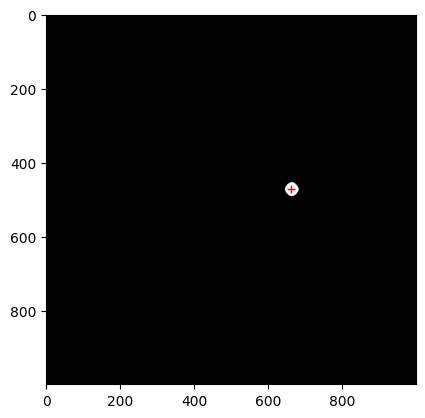

In [100]:
blurredOriginal = cv2.GaussianBlur(testImage, ksize=(41, 41), sigmaX=40)
_, pacbotOriginal = cv2.threshold(blurredOriginal, 200, 255, cv2.THRESH_BINARY)

# Show the centroid
plt.imshow(pacbotOriginal, cmap='gray')                                              # type: ignore

# Calculate the centroid
centroidOriginal = list(map(int, map(np.mean, np.where(pacbotOriginal))))

# Plot a point based on this result
plt.plot([centroidOriginal[1]], [centroidOriginal[0]], "r+")                         # type: ignore

# Perspective Matrix
matrix = four_point_matrix(pointTL, pointTR, pointBL, pointBR, height, width)

# Matrix multiplication to get a vector
vector = matrix @ np.array([centroidOriginal[1], centroidOriginal[0], 1])

# Print out the centroid coordinates
print(f'transformed centroid at (row {int(vector[1]/vector[2])}, col {int(vector[0]/vector[2])})')

As we can see, the localization isn't much different at all! The main source of variation between the two approaches is how the Pacbot (white) color marker might slightly change shape due to the four point transformation. Even then, the two centroids are always within a few rows and columns of each other, so decisions about the Pacbot position within the maze will practically be the same.

## Part 3: Color Localization

### Color Masking

Work-In-Progress

### Retro-Reflectors

Work-In-Progress